# NARR: Subsetting and OPeNDAP

## About the Dataset

This tutorial uses data from NOAA's [North American Regional Reanalysis](https://www.ncei.noaa.gov/products/weather-climate-models/north-american-regional) (NARR)

> The North American Regional Reanalysis (NARR) is a model produced by the National Centers for Environmental Prediction (NCEP) that generates reanalyzed data for temperature, wind, moisture, soil, and dozens of other parameters. The NARR model assimilates a large amount of observational data from a variety of sources to produce a long-term picture of weather over North America.

For this recipe, we will access the data via [OPeNDAP](https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap), a widely-used API for remote access of environmental data over HTTP.
A key point is that, since we use using OPeNDAP, _there are no input files to download / cache_. We open the data directly from the remote server.

The data we will use are catalogged here (3D data on pressure levels): <https://psl.noaa.gov/thredds/catalog/Datasets/NARR/pressure/catalog.html>

Let's peek at one file. Xarray should automatically do the right thing with the OPeNDAP url. But just to be safe, we can pass the option, `engine='netcdf4'`, which is needed to open OPeNDAP links correctly. (We will need this again later when writing our recipe.)

In [1]:
import xarray as xr
url = "https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/air.197901.nc"
ds = xr.open_dataset(url, engine='netcdf4')
ds

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:            (time: 248, level: 29, y: 277, x: 349)
Coordinates:
  * time               (time) datetime64[ns] 1979-01-01 ... 1979-01-31T21:00:00
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
Data variables:
    Lambert_Conformal  int32 ...
    air                (time, level, y, x) float32 ...
Attributes: (12/17)
    Conventions:                     CF-1.2
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    institution:                     National Centers for Environmental Predi...
    latcorners:                      [ 1.000001  0.897945 46.3544   46.63433 ]
    ...                              ...
    history:                         created Fri Jan  8 02:35:07 MST 2016 by ...
    dataset_title:                   NCEP North American Regional Reanalysis ...
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    References:                      
    DODS_EXTRA.Unlimited_Dimension:  time

This is just one file.
But it's a very big file (several GB)!
We will want to use the __subsetting__ capability of `XarrayZarrRecipe`. 
To figure out how to subset, let's examine the `_ChunkSizes` attribute.
This attribute part of the NetCDF4 files that the OPeNDAP server is serving.
We want to make sure our subsetting is compatible with the internal chunking of the files.

In [2]:
ds.air._ChunkSizes

array([  1,   1, 277, 349], dtype=int32)

This tells us that we can subset in the `time` or `level` dimensions, but problably should avoid subsetting in the `x` and `y` dimensions.

## Define File Pattern

We are now ready to define the `FilePattern` for the recipe. There is one file per month. So we start with a function like this:

In [3]:
def format_function(time):
    return f"https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/air.{time}.nc"

To keep things short and simple for this tutorial, we will just use one file, and subset it into many chunks.
But we could easily add more months to build up the entire dataset.
Since each file is monthly, and the number of days per months varies, we cannot set `nitems_per_input` in the `ConcatDim`.

```{note}
It's important that we specify `is_opendap=True` when creating a FilePattern with OPeNDAP URLs.
OPeNDAP is actually an API, so there are no files to download. 
```

In [4]:
from pangeo_forge_recipes.patterns import FilePattern, ConcatDim, MergeDim
time_dim = ConcatDim("time", ["197901"])
pattern = FilePattern(format_function, time_dim, is_opendap=True)
pattern

/Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/patterns.py:171: UserWarning: `is_opendap` passed as `True`, overriding default `file_type.value == 'netcdf4' with `'opendap'`.
  warnings.warn(_overide_warning)


<FilePattern {'time': 1}>

## Define the Recipe

This tutorial introduces a new option we have not seen before: `subset_inpus={"time": 30}`. This tells the `XarrayZarrRecipe` to break each input file into 30 distinct chunks along the `time` dimension. 

Some other points to consider when defining this recipe.
- Since the inputs are OPeNDAP, we want to use `is_opendap=True`.
- Since we have not specified `nitems_per_input` in the `FilePattern`, we need to explicitly set the target chunks.

In [5]:
from pangeo_forge_recipes.recipes import XarrayZarrRecipe
recipe = XarrayZarrRecipe(
    pattern, 
    subset_inputs={"time": 30},
    target_chunks={"time": 1},
)
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 1}>, storage_config=StorageConfig(target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x17b839760>, root_path='/var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmpijan4mig/0ztsPKAE'), cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x17b839760>, root_path='/var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmpijan4mig/Y0D9oe2E'), metadata=MetadataTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x17b839760>, root_path='/var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmpijan4mig/TL1NM4Vs')), inputs_per_chunk=1, target_chunks={'time': 1}, cache_inputs=False, copy_input_to_local_file=False, consolidate_zarr=True, consolidate_dimension_coordinates=True, xarray_open_kwargs={'engine': 'netcdf4'}, xarray_concat_kwargs={}, delete_input_encoding=True, process_input=None, process_chunk=None, lock_timeout=None, subset_inputs={'time': 30}, open_input_with_fsspec_referen

## Run the Recipe

In [6]:
# logging will display some interesting information about our recipe during execution
from pangeo_forge_recipes.recipes import setup_logging

setup_logging()

Here we just use the simple python function executor.

In [7]:
recipe.to_function()()

[03/10/22 10:43:16] INFO     Opening input with Xarray                     ]8;id=402562;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=167096;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Caching metadata for input                    ]8;id=319076;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=316660;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#163\163]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

/Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py:111: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  return xr.open_zarr(target.get_mapper())


                    INFO     Creating a new dataset in target              ]8;id=737528;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=607781;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#504\504]8;;\

                    INFO     Opening inputs for chunk                      ]8;id=310063;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=248657;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

[03/10/22 10:43:17] INFO     Opening input with Xarray                     ]8;id=147649;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=156410;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-0          ]8;id=101554;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=961338;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=141756;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=773047;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[03/10/22 10:43:21] INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=497800;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=52903;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#546\546]8;;\
                             q549zdwhcgg98c0000gn/T/tmpijan4mig/0ztsPKAE                     

                    INFO     Expanding target concat dim 'time' to size    ]8;id=698026;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=771760;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#560\560]8;;\
                             248                                                             

                    INFO     Opening inputs for chunk                      ]8;id=350908;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=307127;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=836336;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=588974;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:43:22] INFO     Subsetting input according to time-0          ]8;id=56257;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=701270;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=565949;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=134574;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=399685;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=305177;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 8, None),)                       

[03/10/22 10:43:40] INFO     Storing variable air chunk                    ]8;id=888203;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=901731;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 8, None),                        
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=976853;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=227323;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=1,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=351386;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=255277;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:43:41] INFO     Subsetting input according to time-1          ]8;id=626080;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=159031;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=672432;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=159249;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=1,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=120590;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=863367;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=1,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(8, 16, None),)                      

[03/10/22 10:43:46] INFO     Storing variable air chunk                    ]8;id=962996;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=414977;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=1,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(8, 16, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=643984;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=156218;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=2,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=587613;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=186659;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:43:47] INFO     Subsetting input according to time-2          ]8;id=219408;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=419153;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=447129;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=616258;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=2,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=492097;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=412019;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=2,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(16, 24, None),)                     

[03/10/22 10:43:53] INFO     Storing variable air chunk                    ]8;id=753593;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=969630;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=2,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(16, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=793461;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=882130;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=3,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=773469;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=713436;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:43:54] INFO     Subsetting input according to time-3          ]8;id=711444;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=261534;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=501060;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=336676;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=3,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=507385;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=829976;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=3,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(24, 32, None),)                     

[03/10/22 10:44:14] INFO     Storing variable air chunk                    ]8;id=902539;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=399398;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=3,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(24, 32, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=84550;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=635169;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=4,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=535538;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=141338;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:44:15] INFO     Subsetting input according to time-4          ]8;id=887037;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=974559;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=775584;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=817395;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=4,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=905321;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=981285;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=4,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(32, 40, None),)                     

[03/10/22 10:44:36] INFO     Storing variable air chunk                    ]8;id=622193;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=809028;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=4,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(32, 40, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=378618;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=395458;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=5,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=767142;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=861290;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:44:37] INFO     Subsetting input according to time-5          ]8;id=777868;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=142524;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=749886;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=226205;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=5,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=909056;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=506605;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=5,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(40, 48, None),)                     

[03/10/22 10:44:42] INFO     Storing variable air chunk                    ]8;id=741474;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=776916;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=5,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(40, 48, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=329464;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=818030;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=6,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=938879;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=72708;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:44:43] INFO     Subsetting input according to time-6          ]8;id=177528;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=180566;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=517849;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=267910;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=6,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=862975;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=856674;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=6,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(48, 56, None),)                     

[03/10/22 10:45:02] INFO     Storing variable air chunk                    ]8;id=253384;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=978373;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=6,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(48, 56, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=743230;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=141723;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=7,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=999807;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=535642;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:45:03] INFO     Subsetting input according to time-7          ]8;id=924225;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=516772;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=96921;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=717405;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=7,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=687872;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=964008;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=7,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(56, 64, None),)                     

[03/10/22 10:45:10] INFO     Storing variable air chunk                    ]8;id=743083;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=100784;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=7,                             
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(56, 64, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=604121;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=36507;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=8,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=213339;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=83994;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:45:11] INFO     Subsetting input according to time-8          ]8;id=584785;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=665704;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=144332;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=342378;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=8,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=790847;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=789646;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=8,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(64, 72, None),)                     

[03/10/22 10:45:19] INFO     Storing variable air chunk                    ]8;id=27836;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=719911;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=8,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(64, 72, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=553661;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=634958;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=9,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=891895;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=602491;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:45:21] INFO     Subsetting input according to time-9          ]8;id=359097;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=130925;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=995800;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=375505;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=9,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=633878;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=568767;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=9,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(72, 80, None),)                     

[03/10/22 10:45:38] INFO     Storing variable air chunk                    ]8;id=706783;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=552196;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=9,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(72, 80, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=246509;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=670291;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=10,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=853869;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=227556;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:45:39] INFO     Subsetting input according to time-10         ]8;id=682944;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=387881;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=936684;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=112846;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=10,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=925518;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=784260;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=10,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(80, 88, None),)                     

[03/10/22 10:45:58] INFO     Storing variable air chunk                    ]8;id=932592;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=397347;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=10,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(80, 88, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=712779;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=586784;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=11,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=58659;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=319518;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:45:59] INFO     Subsetting input according to time-11         ]8;id=683929;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=134846;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=303004;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=603129;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=11,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=403548;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=830307;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=11,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(88, 96, None),)                     

[03/10/22 10:46:08] INFO     Storing variable air chunk                    ]8;id=393689;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=754306;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=11,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(88, 96, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=931285;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=301393;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=12,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=435008;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=808004;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:46:09] INFO     Subsetting input according to time-12         ]8;id=664349;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=210266;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=211187;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=970735;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=12,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=350245;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=533478;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=12,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(96, 104, None),)                    

[03/10/22 10:46:15] INFO     Storing variable air chunk                    ]8;id=417138;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=177725;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=12,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(96, 104, None),                     
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=73149;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=439575;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=13,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=581877;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=262492;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:46:16] INFO     Subsetting input according to time-13         ]8;id=268414;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=857877;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=723507;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=263425;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=13,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=548170;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=208169;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=13,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(104, 112, None),)                   

[03/10/22 10:46:23] INFO     Storing variable air chunk                    ]8;id=84345;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=686733;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=13,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(104, 112, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=666460;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=769932;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=14,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=405306;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=37230;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:46:24] INFO     Subsetting input according to time-14         ]8;id=753620;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=439052;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=890094;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=472779;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=14,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=206921;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=971197;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=14,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(112, 120, None),)                   

[03/10/22 10:46:50] INFO     Storing variable air chunk                    ]8;id=834953;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=780749;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=14,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(112, 120, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=691633;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=934292;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=15,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=256978;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=31851;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:46:51] INFO     Subsetting input according to time-15         ]8;id=651581;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=587577;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=873904;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=134644;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=15,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=929930;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=924997;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=15,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(120, 128, None),)                   

[03/10/22 10:47:03] INFO     Storing variable air chunk                    ]8;id=772307;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=244784;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=15,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(120, 128, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=646984;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=869434;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=16,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=412277;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=614101;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:47:04] INFO     Subsetting input according to time-16         ]8;id=350231;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=254576;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=486152;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=705652;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=16,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=345446;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=184804;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=16,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(128, 136, None),)                   

[03/10/22 10:47:09] INFO     Storing variable air chunk                    ]8;id=313533;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=702245;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=16,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(128, 136, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=642041;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=919530;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=17,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=962359;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=89897;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:47:10] INFO     Subsetting input according to time-17         ]8;id=186792;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=425648;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=904522;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=214729;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=17,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=90382;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=78650;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=17,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(136, 144, None),)                   

[03/10/22 10:47:28] INFO     Storing variable air chunk                    ]8;id=854325;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=56869;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=17,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(136, 144, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=829235;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=859118;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=18,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=49015;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=809010;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:47:29] INFO     Subsetting input according to time-18         ]8;id=231382;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=22910;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=566567;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=351927;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=18,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=283029;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=548958;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=18,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(144, 152, None),)                   

[03/10/22 10:47:34] INFO     Storing variable air chunk                    ]8;id=85720;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=93235;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=18,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(144, 152, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=276203;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=18394;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=19,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=381761;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=369208;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:47:35] INFO     Subsetting input according to time-19         ]8;id=256123;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=165564;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=386731;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=781700;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=19,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=558777;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=437479;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=19,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(152, 160, None),)                   

[03/10/22 10:47:40] INFO     Storing variable air chunk                    ]8;id=23993;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=433367;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=19,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(152, 160, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=147404;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=140500;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=20,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=769300;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=81681;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:47:41] INFO     Subsetting input according to time-20         ]8;id=744545;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=850099;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=145732;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=381414;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=20,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=667567;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=273252;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=20,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(160, 168, None),)                   

[03/10/22 10:47:59] INFO     Storing variable air chunk                    ]8;id=985868;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=982131;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=20,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(160, 168, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=759851;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=240586;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=21,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=991787;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=955666;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:48:00] INFO     Subsetting input according to time-21         ]8;id=646458;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=886005;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=813622;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=127230;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=21,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=383124;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=24950;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=21,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(168, 176, None),)                   

[03/10/22 10:48:18] INFO     Storing variable air chunk                    ]8;id=351489;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=849352;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=21,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(168, 176, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=92949;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=372989;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=22,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=270223;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=642695;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:48:19] INFO     Subsetting input according to time-22         ]8;id=90097;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=947514;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=375901;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=70713;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=22,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=609360;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=116326;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=22,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(176, 184, None),)                   

[03/10/22 10:48:36] INFO     Storing variable air chunk                    ]8;id=844834;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=682776;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=22,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(176, 184, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=860671;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=899824;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=23,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=615897;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=864048;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:48:37] INFO     Subsetting input according to time-23         ]8;id=352110;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=433462;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=788747;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=954206;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=23,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=248758;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=922851;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=23,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(184, 192, None),)                   

[03/10/22 10:48:55] INFO     Storing variable air chunk                    ]8;id=332717;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=528058;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=23,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(184, 192, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=674917;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=583751;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=24,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=880557;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=401963;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:48:56] INFO     Subsetting input according to time-24         ]8;id=254576;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=702711;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=196375;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=385300;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=24,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=577078;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=514576;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=24,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(192, 200, None),)                   

[03/10/22 10:49:01] INFO     Storing variable air chunk                    ]8;id=289450;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=753744;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=24,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(192, 200, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=244284;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=82366;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=25,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=230145;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=808396;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:49:02] INFO     Subsetting input according to time-25         ]8;id=49954;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=336705;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=776205;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=690895;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=25,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=296776;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=587223;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=25,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(200, 208, None),)                   

[03/10/22 10:49:20] INFO     Storing variable air chunk                    ]8;id=991993;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=679346;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>), DimIndex(name='time', index=25,                            
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>)}) to Zarr region (slice(200, 208, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=79408;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=766253;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=26,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=390985;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=669506;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:49:21] INFO     Subsetting input according to time-26         ]8;id=683143;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=422580;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=726001;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=786456;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=26,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=239926;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=891970;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=26,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(208, 216, None),)                   

[03/10/22 10:49:26] INFO     Storing variable air chunk                    ]8;id=739377;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=653948;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=26,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(208, 216, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=157556;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=603540;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=27,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=931870;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=756464;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:49:27] INFO     Subsetting input according to time-27         ]8;id=272105;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=619577;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=692320;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=6137;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=27,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=548364;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=910539;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=27,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(216, 224, None),)                   

[03/10/22 10:49:32] INFO     Storing variable air chunk                    ]8;id=806844;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=715560;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=27,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(216, 224, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=998013;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=382468;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=28,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=577919;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=8418;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:49:33] INFO     Subsetting input according to time-28         ]8;id=724009;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=256377;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=840419;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=101960;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=28,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=122790;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=683062;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=28,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(224, 232, None),)                   

[03/10/22 10:49:50] INFO     Storing variable air chunk                    ]8;id=575420;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=901718;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=28,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(224, 232, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=738501;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=395488;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#386\386]8;;\
                             Index({DimIndex(name='time', index=29,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=768171;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=574226;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/Users//miniconda3/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[03/10/22 10:49:51] INFO     Subsetting input according to time-29         ]8;id=906667;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=543390;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#398\398]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=844454;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=478463;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#404\404]8;;\
                             'Index({DimIndex(name='time', index=29,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=731535;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=238764;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=29,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(232, 248, None),)                   

[03/10/22 10:50:00] INFO     Storing variable air chunk                    ]8;id=775563;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=520455;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#623\623]8;;\
                             Index({DimIndex(name='time', index=29,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(232, 248, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Consolidating dimension coordinate arrays     ]8;id=412568;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=206479;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#640\640]8;;\

                    INFO     Consolidating Zarr metadata                   ]8;id=273092;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=698818;file:///Users//Dropbox/pangeo/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#664\664]8;;\

## Check The Outputs

In [8]:
ds_target =  xr.open_zarr(recipe.target_mapper)
ds_target

<xarray.Dataset>
Dimensions:            (time: 248, level: 29, y: 277, x: 349)
Coordinates:
    lat                (y, x) float32 dask.array<chunksize=(277, 349), meta=np.ndarray>
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
    lon                (y, x) float32 dask.array<chunksize=(277, 349), meta=np.ndarray>
  * time               (time) datetime64[ns] 1979-01-01 ... 1979-01-31T21:00:00
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
Data variables:
    Lambert_Conformal  int32 ...
    air                (time, level, y, x) float32 dask.array<chunksize=(1, 29, 277, 349), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                     CF-1.2
    DODS_EXTRA.Unlimited_Dimension:  time
    References:                      
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    ...                              ...
    platform:                        Model
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    standardpar1:                    50.0
    standardpar2:                    50.000001
    title:                           8x Daily NARR

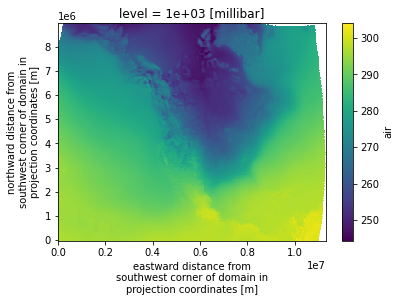

In [9]:
ds_target.air.isel(level=0).mean("time").plot()